In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append('..')
sys.path.append('../src')
import os
from os.path import join as oj
import numpy as np
from copy import deepcopy
import pandas as pd
import data
# import models
import pickle as pkl
# from style import *
import viz
from viz import *
import config
outcome_def = 'y_consec_thresh'

In [2]:
# df = data.get_data(use_processed=True) #, dset='orig') # all_data=True
df = data.get_data(dset='clath_aux_dynamin')
dfv = df[~(df.short | df.long | df.hotspots)]
dfv = dfv[dfv.lifetime > 15] # only keep hard tracks
# dfv = df[df['valid'] == 1] # exclude test cells, short/long tracks, hotspots

In [3]:
dft = dfv[dfv.cell_num.isin(config.DSETS['clath_aux_dynamin']['test'])] # exclude held-out test data

**plot curves (for intro fig)**

<ipython-input-22-4c85d6b8fa5d>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(R, C, 2)
<ipython-input-22-4c85d6b8fa5d>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(R, C, i + 1)


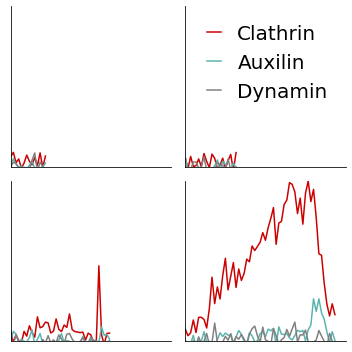

In [22]:
R, C = 2, 2
plt.figure(facecolor='w', figsize=(5, 5))
viz.plot_curves(dfv.iloc[[0, 1, 48, 37]], extra_key='Z', extra_key_label='Dynamin',
                R=R, C=R, fig=True, ylim_constant=True, legend=False, hline=False)
plt.subplot(R, C, 2)
plt.legend(fontsize=20, frameon=False, handlelength=0.7)
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.xlim((0, 60))
viz.savefig('intro_curves')

**plot curves (for examples fig)**

<ipython-input-6-cb13112d8872>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(R, C, 1)
<ipython-input-6-cb13112d8872>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(R, C, 1)


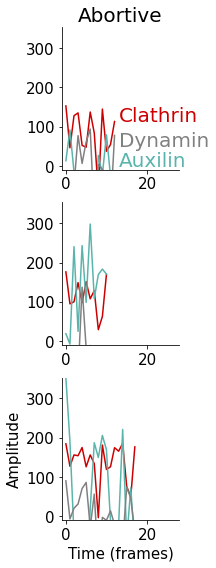

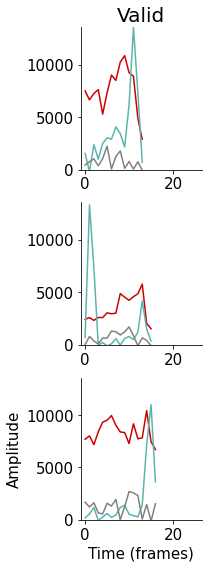

In [6]:
plt.figure(figsize=(3, 8))
R, C = 3, 1
dfv_minus = dfv[dfv[outcome_def] == 0].sort_values('X_max')
viz.plot_curves(dfv_minus, R=R, C=C, fig=True, extra_key='Z',
                ylim_constant=True, legend=False, hline=False)
plt.xlabel('Time (frames)')
plt.ylabel('Amplitude')
plt.subplot(R, C, 1)
# plt.legend(fontsize=18)
r = dfv_minus.iloc[0]
plt.text(len(r.X), r.X[-1], 'Clathrin', color=cr, fontsize=20)
# plt.title('A', loc='left', fontweight='bold')
plt.text(len(r.Z), 50, 'Dynamin', color='gray', fontsize=20)
plt.text(len(r.Y), 0, 'Auxilin', color=cg, fontsize=20)
plt.title('Abortive')
plt.tight_layout()
viz.savefig('traces_minus')
# plt.savefig('figs/fig_traces_minus.pdf')

plt.figure(figsize=(3, 8))
dfv_plus = dfv[(dfv[outcome_def] == 1) & (dfv.lifetime < 50)].sort_values('Y_max', ascending=False)
viz.plot_curves(dfv_plus, R=R, C=C, fig=True, extra_key='Z',
                ylim_constant=True, legend=False, hline=False)
plt.xlabel('Time (frames)')
plt.ylabel('Amplitude')
plt.subplot(R, C, 1)
# plt.title('B', loc='left', fontweight='bold')
plt.title('Valid')
plt.tight_layout()
viz.savefig('traces_plus')
# plt.savefig('figs/fig_traces_plus.pdf')

## extract and plot videos

In [53]:
cla_videos, aux_videos = viz.get_dynamin_data_video(dfv_minus, dfv_minus.pid.values[:3])

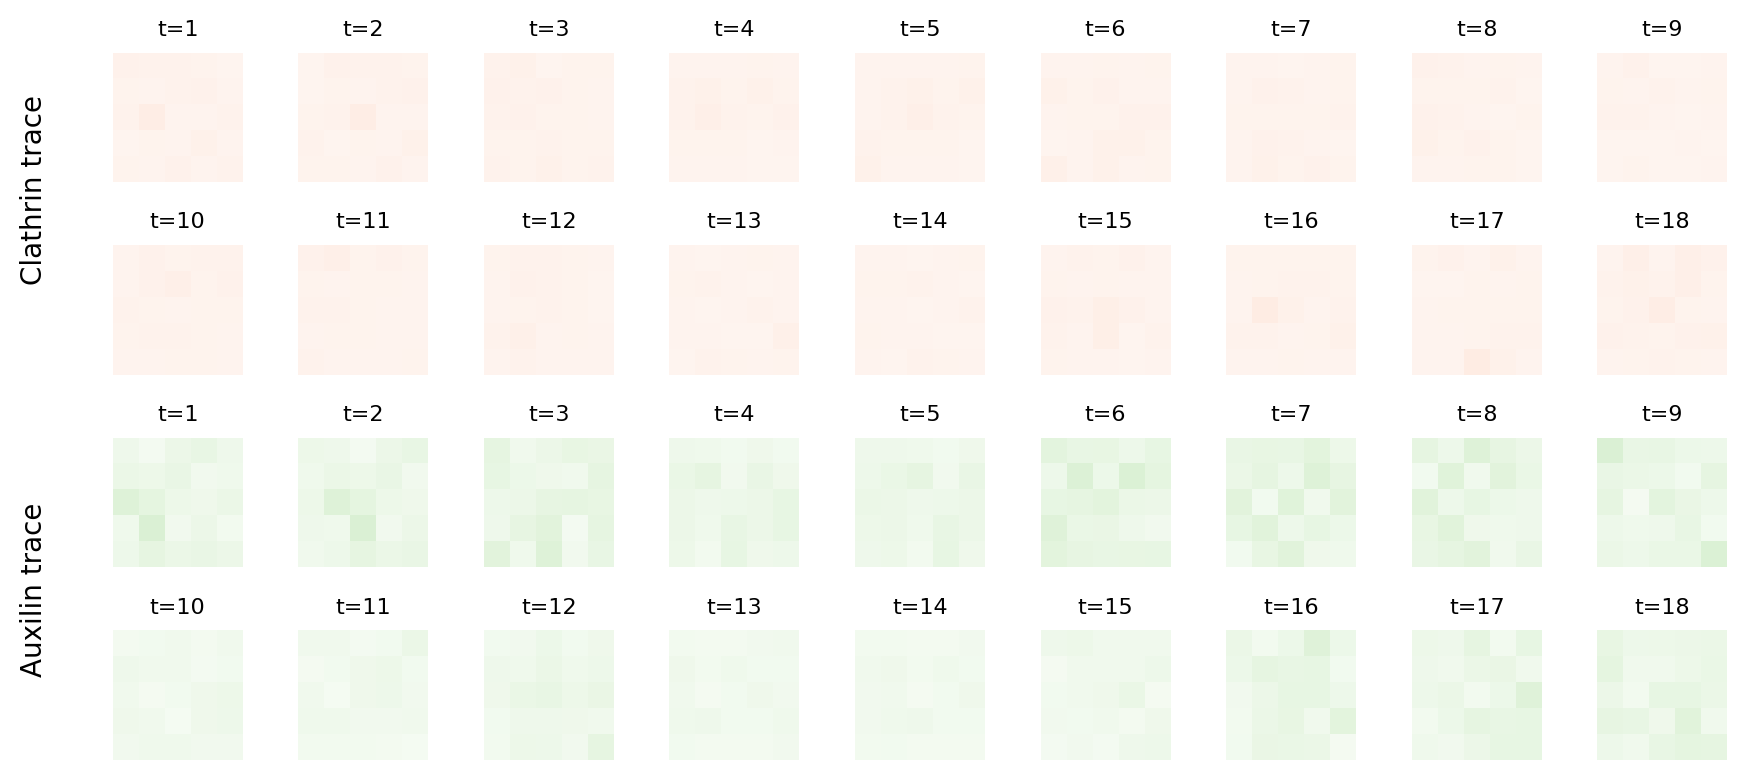

In [54]:
pid = dfv_minus.pid.values[2]
n = len(aux_videos[pid])

fig = plt.figure(figsize=(9, 4), dpi=200)
for i in range(len(cla_videos[pid])):
    ax = plt.subplot(4, 9, i + 1)
    ax.imshow(cla_videos[pid][i], vmin=0, vmax=1, cmap='Reds') # Auxilin
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(label=f't={i + 1}', fontsize=8)
#plt.tight_layout()

#plt.figure(figsize=(6, 3), dpi=200)
for i in range(len(aux_videos[pid])):
    ax = plt.subplot(4, 9, i + 19)
    ax.imshow(aux_videos[pid][i], vmin=0, vmax=1, cmap='Greens') # Auxilin
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(label=f't={i + 1}', fontsize=8)
fig.text(0, 0.75, 'Clathrin trace', va='center', rotation='vertical')
fig.text(0, 0.25, 'Auxilin trace', va='center', rotation='vertical')
plt.tight_layout()

viz.savefig('abortive_example')

# viz hists

In [ ]:
outcome = df[outcome_def]
R, C = 2, 1


plt.figure(figsize=(6, 12), dpi=200)
plt.subplot(R, C, 1)
# plt.title('C', loc='left', fontweight='bold')
plt.title('All events')
plt.hist(df['lifetime'][outcome == 1], label='Valid', alpha=1, color=cb, bins=25)
plt.hist(df['lifetime'][outcome == 0], label='Abortive', alpha=0.7, color=co, bins=25)
plt.xlabel('Lifetime')
plt.ylabel('Count')
plt.legend(fontsize=18, frameon=False)
plt.yscale('log')

plt.subplot(R, C, 2)
plt.hist(df['X_max'][outcome == 1], label='Valid', alpha=1, color=cb, bins=25)
plt.hist(df['X_max'][outcome == 0], label='Abortive', alpha=0.7, color=co, bins=25)
plt.xlabel('Clathrin max amplitude')
plt.ylabel('Count')
plt.yscale('log')

'''
plt.subplot(R, C, 3)
plt.hist(df['fall'][outcome == 1], label='aux+', alpha=1, color=cb, bins=25)
plt.hist(df['fall'][outcome == 0], label='aux-', alpha=0.7, color=cr, bins=25)
plt.xlabel('Fall')
plt.ylabel('Count')
'''
plt.tight_layout()
viz.savefig('hists')
# plt.savefig('figs/fig_hists.pdf')
plt.show()

# dset sizes

In [ ]:
viz.print_metadata(acc=None, metadata_file='processed/metadata_clath_aux.pkl')

In [85]:
df_test = df[df.cell_num.isin(config.SPLITS['orig']['test'])]

In [88]:
print('valid', df_test.shape[0], df_test[outcome_def].sum())

valid 2497 561.0


In [91]:
d = df_test[~df_test['short'] & ~df_test['long']]
print('difficult', d.shape[0], d[outcome_def].sum())

difficult 1045 469.0
